In [1]:
import zlib
from PIL import Image

In [2]:
class DataHelper:
    def __init__(self, filename):
        with open(filename, 'rb') as file:
            self._content = file.read()

        self._pointer = 0

    def read(self, nbytes):
        value = self._content[self._pointer:self._pointer + nbytes]
        self._pointer += nbytes
        return value

    def read_int(self, nbytes, signed):
        return int.from_bytes(self.read(nbytes), byteorder='little', signed=signed)

    def read_at(self, pos, nbytes):
        print(pos, pos+nbytes)
        return self._content[pos:pos+nbytes]

def intsToStr(arr):
    return ''.join(chr(y-128) if y >= 128 else '\0' for x in arr for y in x.to_bytes(4, 'big'))

In [3]:
data = DataHelper('HeyTux2.map')

In [4]:
# TODO: calculate crc/sha256?

In [5]:
# read header
header = {}

header['magic'] = data.read(4)

for x in ['version', 'size', 'swaplen', 'numitemtypes', 'numitems', 'numdata', 'itemsize', 'datasize']:
    header[x] = data.read_int(4, True)

header

{'magic': b'DATA',
 'version': 4,
 'size': 842067,
 'swaplen': 2284,
 'numitemtypes': 7,
 'numitems': 28,
 'numdata': 27,
 'itemsize': 1852,
 'datasize': 839783}

In [6]:
# read itemtypes
itemtypes = []

for _ in range(header['numitemtypes']):
    newtype = {}
    for x in ['type_id', 'start', 'num']:
        newtype[x] = data.read_int(4, True)
    itemtypes.append(newtype)

itemtypes

[{'type_id': 0, 'start': 0, 'num': 1},
 {'type_id': 1, 'start': 1, 'num': 1},
 {'type_id': 2, 'start': 2, 'num': 7},
 {'type_id': 3, 'start': 9, 'num': 1},
 {'type_id': 4, 'start': 10, 'num': 4},
 {'type_id': 5, 'start': 14, 'num': 13},
 {'type_id': 6, 'start': 27, 'num': 1}]

In [7]:
# read offsets / sizes
item_offsets = [data.read_int(4, True) for _ in range(header['numitems'])]
data_offsets = [data.read_int(4, True) for _ in range(header['numdata'])]
data_sizes = [data.read_int(4, True) for _ in range(header['numdata'])] # note: only if version==4

In [8]:
items = []

for item_type in itemtypes:
    for _ in range(item_type['num']):

        item = {}

        type_and_id = data.read_int(4, False)
        item['type'] = (type_and_id >> 16) & 0xffff
        item['id'] = type_and_id & 0xffff
        item['size'] = data.read_int(4, True) # must be divisible by 4
        item['data'] = {}

        if item_type['type_id'] == 0: # version
            item['data']['version'] = data.read_int(4, True)
        elif item_type['type_id'] == 1: # info
            item['data']['version'] = data.read_int(4, True)
            item['data']['author'] = data.read_int(4, True)
            item['data']['map_version'] = data.read_int(4, True)
            item['data']['credits'] = data.read_int(4, True)
            item['data']['license'] = data.read_int(4, True)
            item['data']['settings'] = data.read_int(4, True) # note: DDNet Only
        elif item_type['type_id'] == 2: # image
            item['data']['version'] = data.read_int(4, True)
            item['data']['width'] = data.read_int(4, True)
            item['data']['height'] = data.read_int(4, True)
            item['data']['external'] = data.read_int(4, True)
            item['data']['name'] = data.read_int(4, True)
            item['data']['data'] = data.read_int(4, True)
            # note: vanilla only: variant
        elif item_type['type_id'] == 3: # envelope
            item['data']['version'] = data.read_int(4, True)
            item['data']['channels'] = data.read_int(4, True)
            item['data']['start_point'] = data.read_int(4, True)
            item['data']['num_points'] = data.read_int(4, True)
            item['data']['name'] = data.read(32) # note: extension
            item['data']['synchronized'] = data.read_int(4, True) # note: extension
        elif item_type['type_id'] == 4: # group
            item['data']['version'] = data.read_int(4, True)
            item['data']['x_offset'] = data.read_int(4, True)
            item['data']['y_offset'] = data.read_int(4, True)
            item['data']['x_parallax'] = data.read_int(4, True)
            item['data']['y_parallax'] = data.read_int(4, True)
            item['data']['start_layer'] = data.read_int(4, True)
            item['data']['num_layers'] = data.read_int(4, True)

            # note: extension (version 2)
            item['data']['clipping'] = data.read_int(4, True)
            item['data']['clip_x'] = data.read_int(4, True)
            item['data']['clip_y'] = data.read_int(4, True)
            item['data']['clip_width'] = data.read_int(4, True)
            item['data']['clip_height'] = data.read_int(4, True)

            # note: extension (version 3)
            item['data']['name'] = data.read(12)
        elif item_type['type_id'] == 5: # layer
            item['data']['version'] = data.read_int(4, True) # note: uninitialized
            item['data']['type'] =  data.read_int(4, True)
            item['data']['flags'] = data.read_int(4, True)

            if item['data']['type'] == 2: # tilemap
                pass
            elif item['data']['type'] == 3: # quads
                pass
            elif item['data']['type'] == 9: # depr_sounds
                pass
            elif item['data']['type'] == 10: # sounds
                pass
        elif item_type['type_id'] == 6: # envelope point
            pass
        elif item_type['type_id'] == 0xffff: # uuid index
            pass
        else:
            raise 'Unknown typeid'

        items.append(item)

In [9]:
items[2]

{'type': 2,
 'id': 0,
 'size': 24,
 'data': {'version': 1,
  'width': 1024,
  'height': 1024,
  'external': 0,
  'name': 0,
  'data': 1}}

In [10]:
# calculate offset of data section from file begin
size = header['numitemtypes'] * 12
size += (header['numitems'] + header['numdata']) * 4
if header['version'] == 4:
    size += header['numdata'] * 4
size += header['itemsize']
size += 36
size

2300

120319


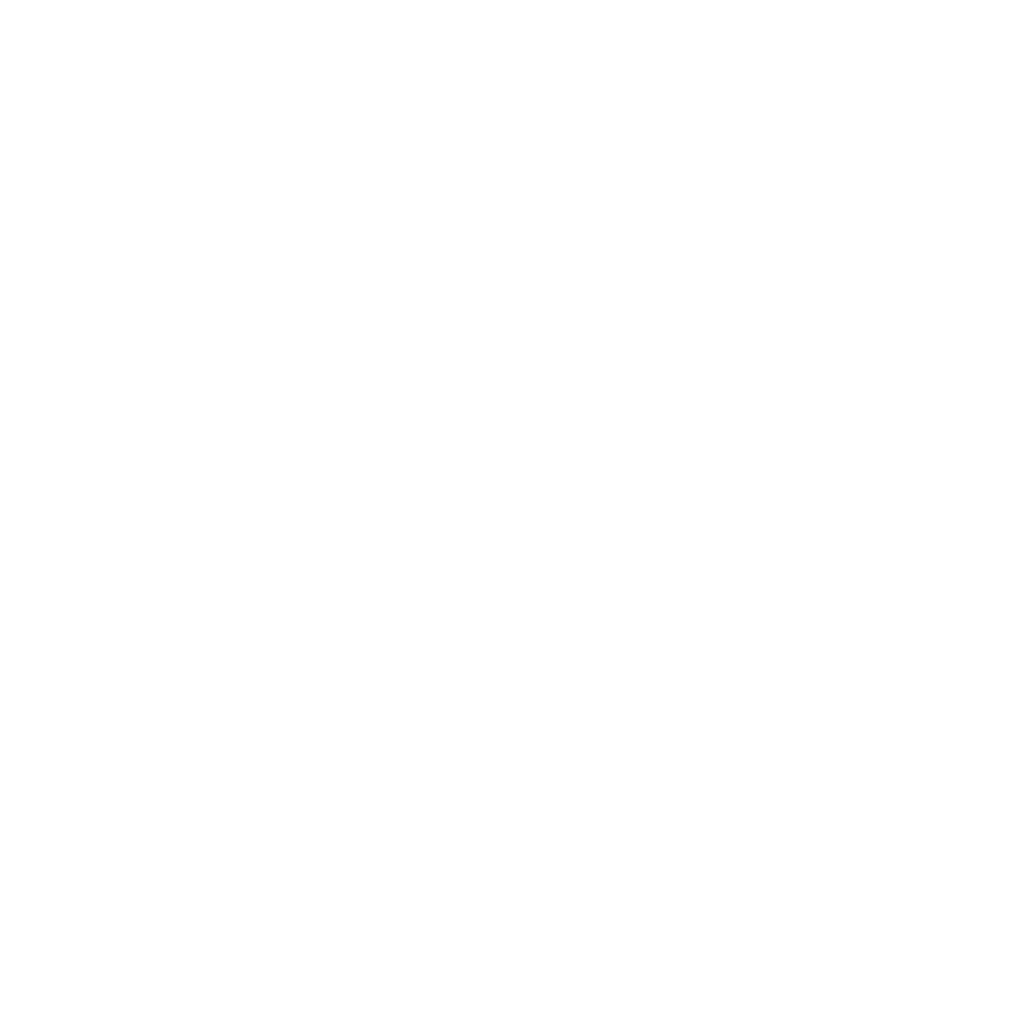

In [14]:
# decompress images
testitem = items[2]

offset = data_offsets[testitem['data']['data']]
next_offset = data_offsets[testitem['data']['data'] + 1]
print(next_offset - offset)
im_data = data.read_at(size + offset, next_offset - offset)
Image.frombytes('RGBA', (testitem['data']['width'], testitem['data']['height']), zlib.decompress(im_data))

In [13]:
data_offsets

[0,
 14,
 120333,
 120354,
 130880,
 130900,
 193883,
 193905,
 217796,
 217815,
 281229,
 281249,
 281274,
 281340,
 282047,
 751367,
 764656,
 766997,
 768947,
 769965,
 771915,
 773957,
 783015,
 785059,
 787107,
 800236,
 837748]